# Dependency Analysis 

## Setting Up the Environment

### Import Libraries

In [1]:
from neo4j import GraphDatabase
from py2neo import Graph
import pandas as pd
import networkx as nx
from networkx.algorithms.community import girvan_newman
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Connecting to Neo4j

In [2]:
bolt_url = "bolt://localhost:7687"  # Use the correct bolt URL
username = "neo4j"
password = "password"

driver = GraphDatabase.driver(bolt_url, auth=(username, password))
graph = Graph(bolt_url, auth=(username, password)) 

## Fetching Data from Neo4j

In [3]:
# Fetching Data from Neo4j
def fetch_data(query, params=None):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([dict(record) for record in result])

## Building the Dependency Graph

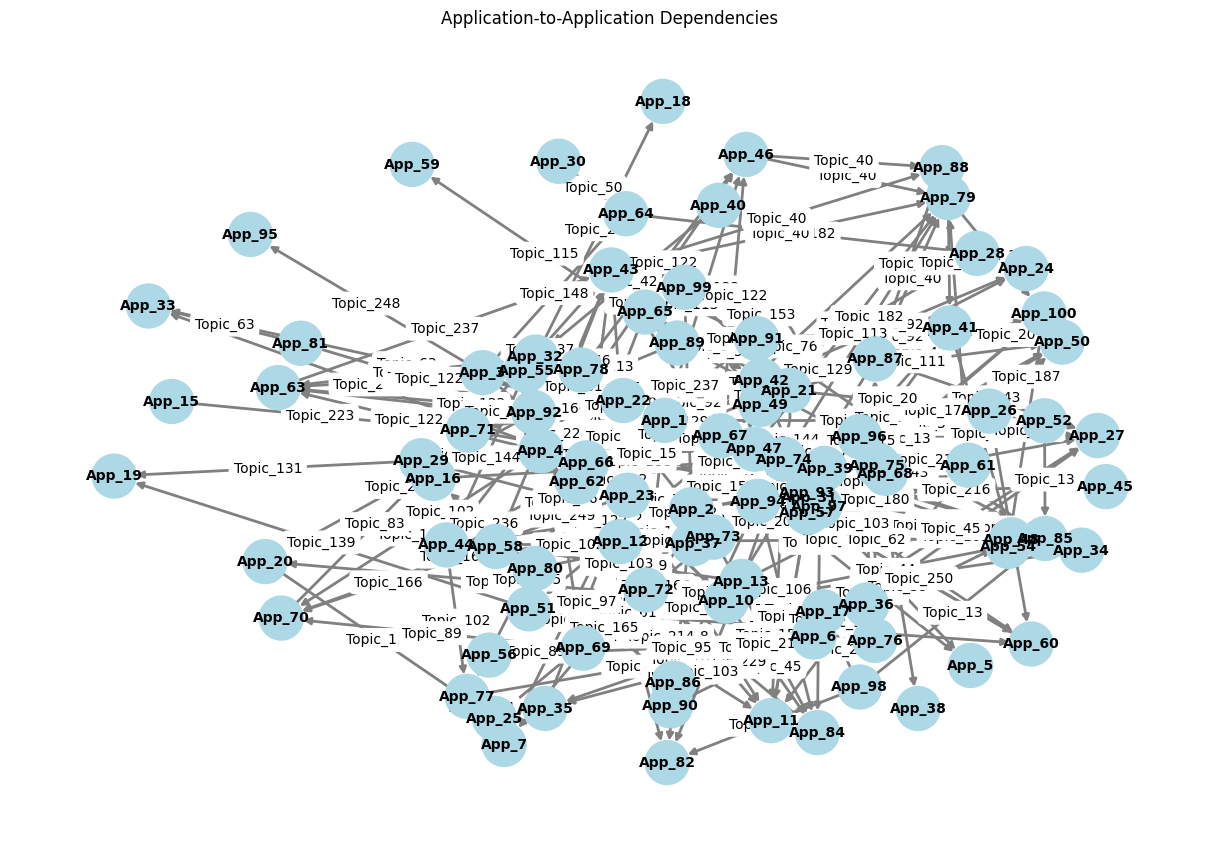

In [4]:
# Query to get all relationships between Applications
dependency_query = """
MATCH (a1:Application)-[:PUBLISHES_TO]->(t:Topic)<-[:SUBSCRIBES_TO]-(a2:Application)
RETURN a1.name AS publisher, a2.name AS subscriber, t.name AS topic
"""
df_dependencies = fetch_data(dependency_query)

# Create a directed graph
G = nx.from_pandas_edgelist(
    df_dependencies, 
    source='publisher', 
    target='subscriber', 
    edge_attr='topic', 
    create_using=nx.DiGraph()
)

# Draw the graph with adjusted layout and size
plt.figure(figsize=(12, 8))  # Adjust figure size for better clarity
pos = nx.spring_layout(G, k=0.5, seed=42)  # Increase k to spread out nodes
colors = [G.nodes[node].get("color", "lightblue") for node in G.nodes]
edge_labels = nx.get_edge_attributes(G, 'topic')
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, font_size=10, font_weight="bold", edge_color="gray", width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.5, rotate=False)
plt.title("Application-to-Application Dependencies")
plt.show()

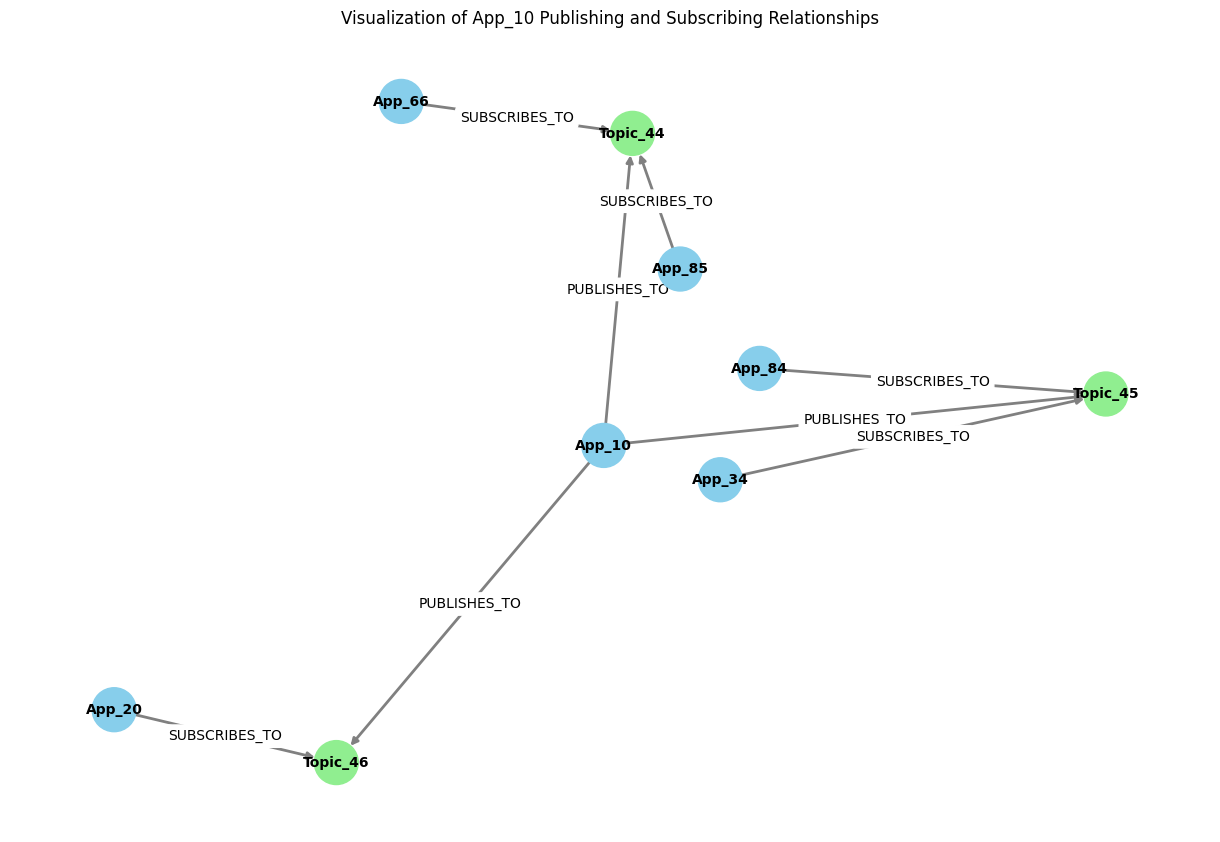

In [5]:
def visualize_applications(name):
    query = """
    MATCH (a1:Application {name: $name})-[:PUBLISHES_TO]->(t:Topic)<-[:SUBSCRIBES_TO]-(a2:Application)
    RETURN a1, t, a2
    """
    result = graph.run(query, name=name)

    G = nx.DiGraph()

    for record in result:
        a1 = record["a1"]
        t = record["t"]
        a2 = record["a2"]

        G.add_node(a1["name"], label="Application", color="skyblue")
        G.add_node(t["name"], label="Topic", color="lightgreen")
        G.add_node(a2["name"], label="Application", color="skyblue")

        G.add_edge(a1["name"], t["name"], label="PUBLISHES_TO")
        G.add_edge(a2["name"], t["name"], label="SUBSCRIBES_TO")

    # Draw the graph with adjusted layout and size
    plt.figure(figsize=(12, 8))  # Adjust figure size for better clarity
    pos = nx.spring_layout(G, k=0.5, seed=42)  # Increase k to spread out nodes
    colors = [G.nodes[node].get("color", "lightgray") for node in G.nodes]
    labels = nx.get_edge_attributes(G, "label")

    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=1000, font_size=10, font_weight="bold", edge_color="gray", width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10, label_pos=0.5, rotate=False)

    plt.title(f"Visualization of {name} Publishing and Subscribing Relationships")
    plt.show()

# Example usage
visualize_applications("App_10")

## Identifying Tightly Coupled Applications

In [6]:
# Find strongly connected components
scc = list(nx.strongly_connected_components(G))
# Filter components with more than one node
tightly_coupled_apps = [c for c in scc if len(c) > 1]
print("Tightly Coupled Applications:")
for component in tightly_coupled_apps:
    print(component)
print("Number of Tightly Coupled Applications:", len(tightly_coupled_apps[0]))

Tightly Coupled Applications:
{'App_31', 'App_11'}
{'App_96', 'App_57', 'App_56', 'App_26', 'App_70', 'App_6', 'App_47', 'App_23', 'App_32', 'App_76', 'App_10', 'App_20', 'App_35', 'App_25', 'App_22', 'App_60', 'App_69', 'App_72', 'App_1', 'App_73', 'App_66', 'App_92', 'App_71', 'App_93', 'App_44', 'App_55', 'App_78', 'App_87', 'App_67', 'App_16', 'App_42', 'App_77'}
Number of Tightly Coupled Applications: 2


## Visualizing the Tightly Coupled Components

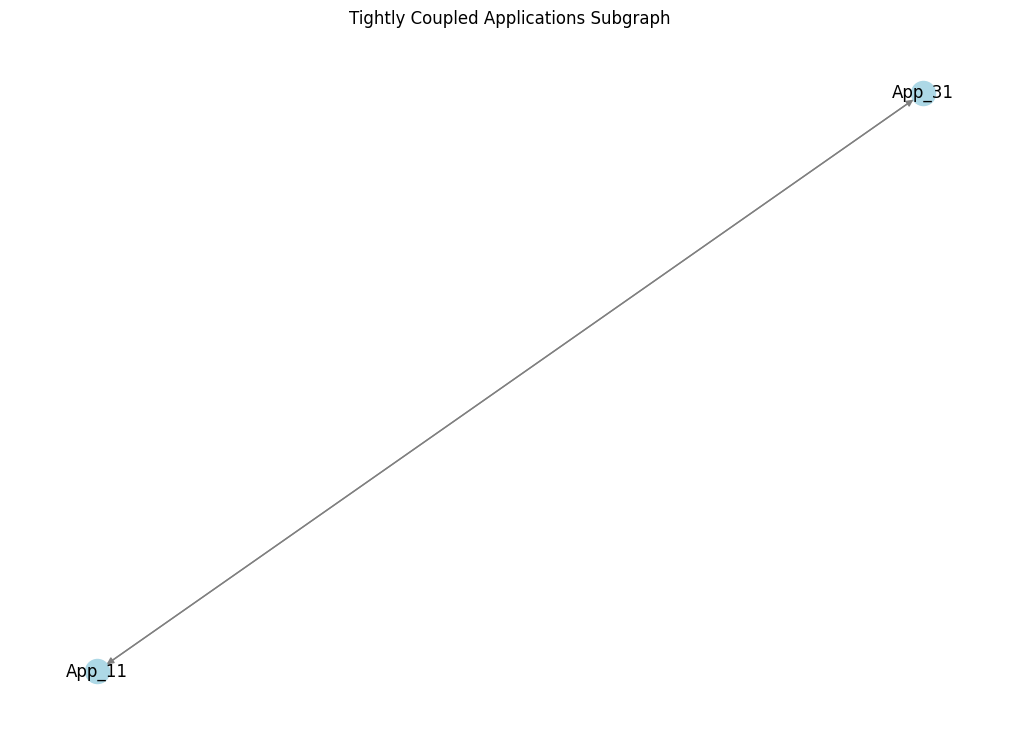

In [7]:
# Visualize one of the tightly coupled components
components = tightly_coupled_apps[0]
subgraph = G.subgraph(components)

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Tightly Coupled Applications Subgraph')
plt.show()

## Analyzing Dependency Chains

In [8]:
# Find all simple paths between applications exceeding a certain length
long_paths = []
for source in G.nodes:
    for target in G.nodes:
        if source != target:
            paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=5))
            for path in paths:
                if len(path) > 4: # Adjust the length as needed
                    long_paths.append(path)

print("Top 10 Long Paths:")
long_paths = sorted(long_paths, key=len, reverse=True)[:10]
for path in long_paths:
    print(" -> ".join(path))


Top 10 Long Paths:
App_47 -> App_1 -> App_72 -> App_86 -> App_94 -> App_34
App_47 -> App_1 -> App_63 -> App_43 -> App_79 -> App_41
App_47 -> App_61 -> App_11 -> App_31 -> App_50 -> App_41
App_47 -> App_1 -> App_72 -> App_86 -> App_94 -> App_43
App_47 -> App_1 -> App_46 -> App_79 -> App_41 -> App_48
App_47 -> App_1 -> App_92 -> App_20 -> App_25 -> App_73
App_47 -> App_1 -> App_72 -> App_86 -> App_94 -> App_84
App_47 -> App_61 -> App_11 -> App_31 -> App_52 -> App_85
App_47 -> App_1 -> App_63 -> App_43 -> App_79 -> App_100
App_1 -> App_72 -> App_47 -> App_61 -> App_11 -> App_31


## Identifying Bottlenecks

In [9]:
# Calculate in-degree and out-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

# Find top 10 applications with highest in-degree (most subscribers)
top_subscribed_apps = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Applications with Most Subscribers:")
for app, centrality in top_subscribed_apps:
    print(f"Application: {app};\tSubscribers: {G.in_degree(app)};\tCentrality: {centrality};")

print("\n")

# Find top 10 applications with highest out-degree (most publishers)
top_publishing_apps = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Applications Publishing to Many Subscribers:")
for app, centrality in top_publishing_apps:
    print(f"Application: {app};\tPublishers: {G.out_degree(app)};\tCentrality: {centrality}")

Top 10 Applications with Most Subscribers:
Application: App_43;	Subscribers: 8;	Centrality: 0.0851063829787234;
Application: App_85;	Subscribers: 8;	Centrality: 0.0851063829787234;
Application: App_79;	Subscribers: 7;	Centrality: 0.07446808510638298;
Application: App_11;	Subscribers: 6;	Centrality: 0.06382978723404255;
Application: App_41;	Subscribers: 6;	Centrality: 0.06382978723404255;
Application: App_27;	Subscribers: 5;	Centrality: 0.05319148936170213;
Application: App_71;	Subscribers: 5;	Centrality: 0.05319148936170213;
Application: App_63;	Subscribers: 5;	Centrality: 0.05319148936170213;
Application: App_84;	Subscribers: 5;	Centrality: 0.05319148936170213;
Application: App_86;	Subscribers: 5;	Centrality: 0.05319148936170213;


Top 10 Applications Publishing to Many Subscribers:
Application: App_42;	Publishers: 9;	Centrality: 0.09574468085106383
Application: App_1;	Publishers: 8;	Centrality: 0.0851063829787234
Application: App_66;	Publishers: 8;	Centrality: 0.0851063829787234
Appl

In [10]:
threshold = 5  # Set an appropriate threshold
query = f"""
MATCH (a:Application)
OPTIONAL MATCH (a)-[r]-()
WITH a, COUNT(r) AS Degree
WHERE Degree > {threshold}
RETURN a.name AS Application, Degree
ORDER BY Degree DESC
LIMIT 10
"""

result = fetch_data(query)
print("Top 10 Applications with High Degree:")
print(result)

Top 10 Applications with High Degree:
  Application  Degree
0      App_42      40
1      App_66      29
2      App_31      29
3      App_47      28
4      App_52      27
5      App_23      27
6      App_72      25
7      App_11      25
8      App_71      25
9      App_79      25


In [11]:
threshold = 10  # Set an appropriate threshold
query = f"""
MATCH (n:Node)<-[:RUNS_ON]-(a:Application)
WITH n, COUNT(a) AS appCount
WHERE appCount > {threshold}
RETURN n.name AS Node, appCount
ORDER BY appCount DESC
"""

result = fetch_data(query)
print(f"Nodes with more than {threshold} applications running:")
for index, row in result.iterrows():
    print(f"{row['Node']} has {row['appCount']} applications running")

Nodes with more than 10 applications running:
Node_6 has 16 applications running
Node_7 has 13 applications running
Node_2 has 12 applications running
Node_10 has 12 applications running
Node_8 has 11 applications running
Node_9 has 11 applications running


In [12]:
query = """
MATCH (b:Broker)
OPTIONAL MATCH (b)-[r]-()
WITH b, COUNT(r) AS Degree
RETURN b.name AS Broker, Degree
ORDER BY Degree DESC
"""

result = fetch_data(query)
print(f"Brokers with more than {threshold} dependencies:")
for index, row in result.iterrows():
    print(f"{row['Broker']} has {row['Degree']} dependencies")

Brokers with more than 10 dependencies:
Broker_2 has 372 dependencies
Broker_1 has 367 dependencies


## Performing Dependency Analysis

### Fetching Application-to-Application Dependencies

In [13]:
dependency_query = """
MATCH (a1:Application)-[d:DEPENDS_ON]->(a2:Application)
RETURN a1.name AS dependent_app, a2.name AS dependency_app, d.via AS topic
"""
df_app_dependencies = fetch_data(dependency_query)

### Building the Dependency Graph

In [14]:
# Create a directed graph for application dependencies
G_app_dep = nx.from_pandas_edgelist(
    df_app_dependencies,
    source='dependency_app',
    target='dependent_app',
    edge_attr='topic',
    create_using=nx.DiGraph()
)

### Identifying Critical Applications

In [15]:
out_degree_centrality = nx.out_degree_centrality(G_app_dep)
critical_apps = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Critical Applications:")
for app, centrality in critical_apps:
    print(f"Application: {app};\tDependencies: {G_app_dep.out_degree(app)};\tCentrality: {centrality}")


Top 10 Critical Applications:
Application: App_42;	Dependencies: 9;	Centrality: 0.09574468085106383
Application: App_1;	Dependencies: 8;	Centrality: 0.0851063829787234
Application: App_66;	Dependencies: 8;	Centrality: 0.0851063829787234
Application: App_93;	Dependencies: 7;	Centrality: 0.07446808510638298
Application: App_23;	Dependencies: 6;	Centrality: 0.06382978723404255
Application: App_4;	Dependencies: 6;	Centrality: 0.06382978723404255
Application: App_10;	Dependencies: 5;	Centrality: 0.05319148936170213
Application: App_21;	Dependencies: 5;	Centrality: 0.05319148936170213
Application: App_73;	Dependencies: 5;	Centrality: 0.05319148936170213
Application: App_47;	Dependencies: 5;	Centrality: 0.05319148936170213


### Visualizing Application Dependencies

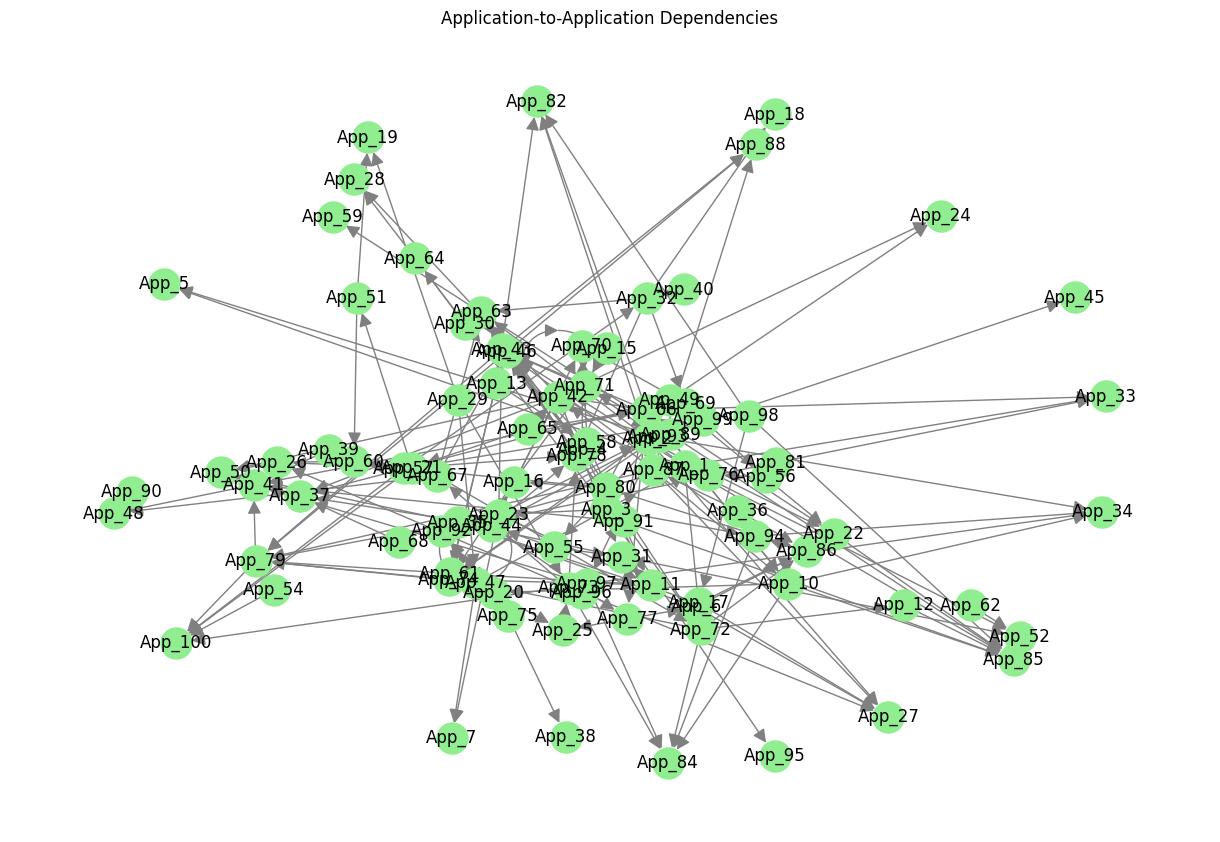

In [16]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_app_dep, k=0.15)
nx.draw(G_app_dep, pos, with_labels=True, node_size=500, node_color='lightgreen', edge_color='gray', arrowsize=20)
plt.title('Application-to-Application Dependencies')
plt.show()

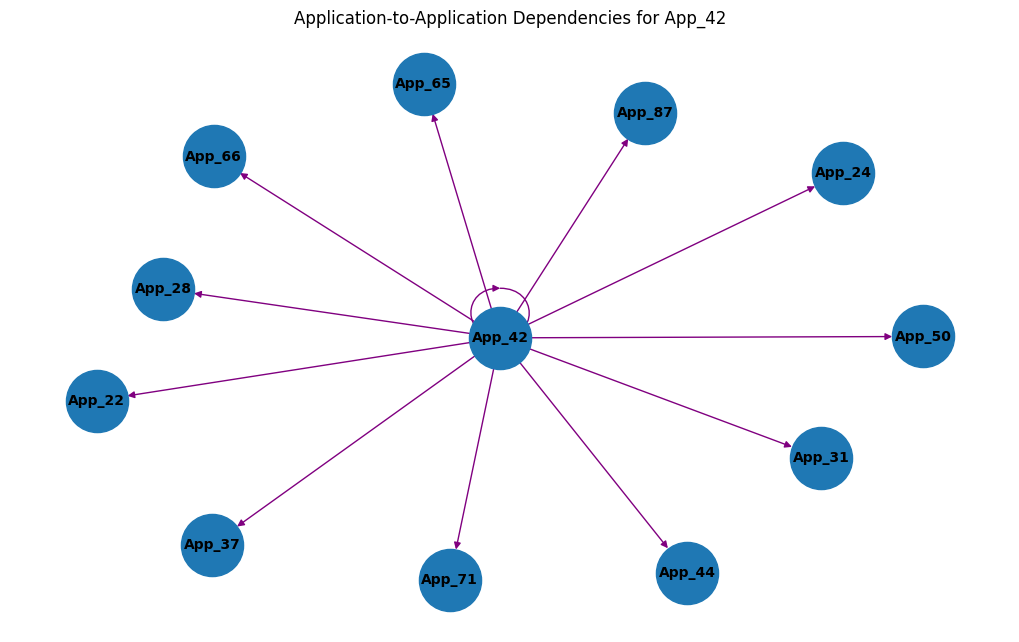

In [17]:
def visualize_application_to_application_dependencies(application_name):
    G = nx.DiGraph()

    indirect_query = f"""
    MATCH (a1:Application {{name: '{application_name}'}})-[d:DEPENDS_ON]-(a2:Application)
    RETURN DISTINCT a1.name AS Publisher, a2.name AS Subscriber
    """
    result = graph.run(indirect_query)
    for record in result:
        G.add_edge(record["Publisher"], record["Subscriber"], color="purple")

    # Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_size=2000, font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"Application-to-Application Dependencies for {application_name}")
    plt.show()

application_name = critical_apps[0][0]
visualize_application_to_application_dependencies(application_name)


### Fetching Application-to-Broker Dependencies

In [18]:
dependency_query = """
MATCH (a:Application)-[d:DEPENDS_ON]->(b:Broker)
RETURN a.name AS application, b.name AS broker, d.via AS topic, d.role AS role
"""
df_app_broker_dependencies = fetch_data(dependency_query)


### Analyzing Broker Load

In [19]:
broker_dependency_count = df_app_broker_dependencies.groupby('broker').application.count().reset_index()
broker_dependency_count.columns = ['broker', 'dependent_app_count']
print(broker_dependency_count)

     broker  dependent_app_count
0  Broker_1                  244
1  Broker_2                  243


### Visualizing Broker Dependencies

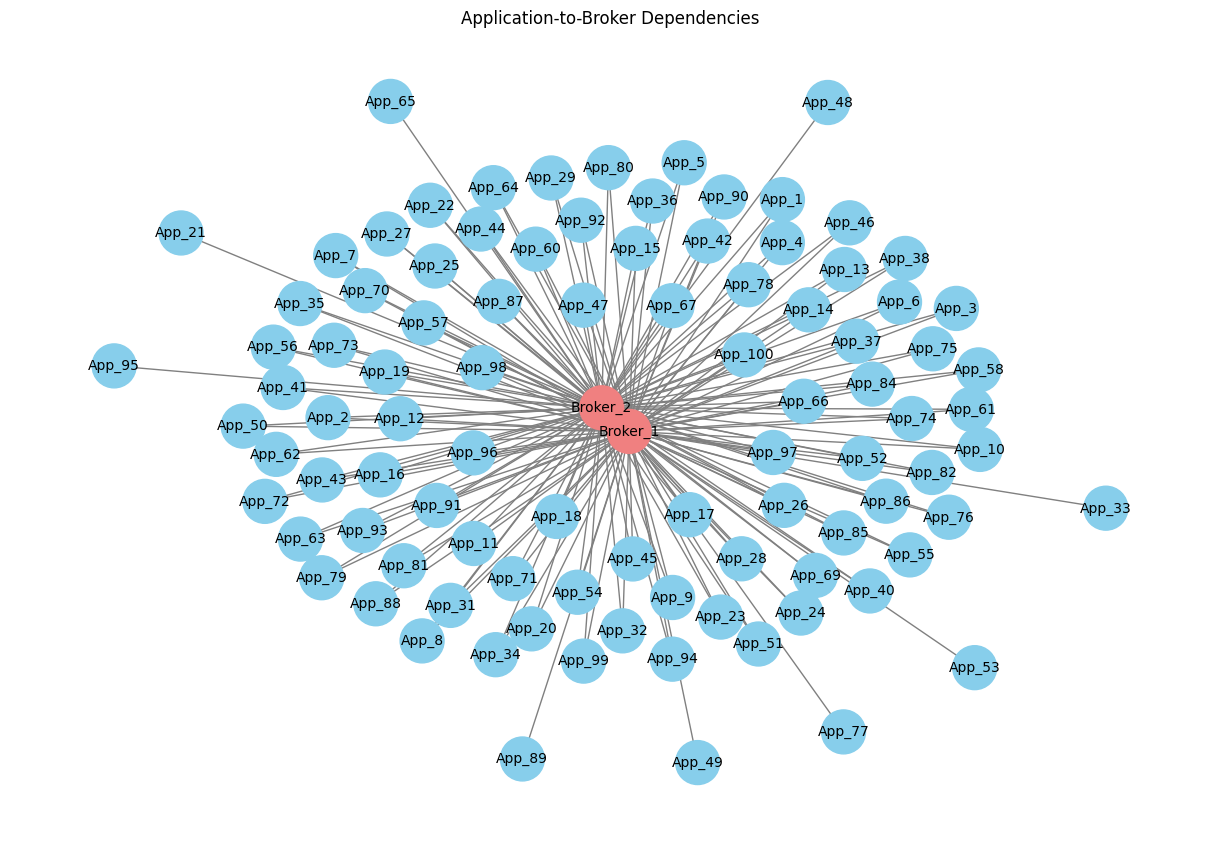

In [20]:
# Create bipartite graph
B = nx.Graph()
applications = df_app_broker_dependencies['application'].unique()
brokers = df_app_broker_dependencies['broker'].unique()

B.add_nodes_from(applications, bipartite=0)
B.add_nodes_from(brokers, bipartite=1)
edges = list(zip(df_app_broker_dependencies['application'], df_app_broker_dependencies['broker']))
B.add_edges_from(edges)

# Plotting the bipartite graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(B)
nx.draw(B, pos, with_labels=True, node_size=1000, font_size=10, node_color=['skyblue' if node in applications else 'lightcoral' for node in B.nodes], edge_color='gray')
plt.title('Application-to-Broker Dependencies')
plt.show()

### Fetching Node-to-Node Dependencies

In [21]:
# Fetch Node-to-Node Dependencies via Applications
query_app_nodes = """
MATCH (n1:Node)-[c:CONNECTS_TO {type: 'application'}]->(n2:Node)
RETURN n1.name AS node1, n2.name AS node2, c.via AS via_apps
"""

df_node_app_dependencies = fetch_data(query_app_nodes)

# Fetch Node-to-Node Dependencies via Brokers
query_broker_nodes = """
MATCH (n1:Node)-[c:CONNECTS_TO {type: 'broker'}]->(n2:Node)
RETURN n1.name AS node1, n2.name AS node2, c.via AS via_brokers
"""

df_node_broker_dependencies = fetch_data(query_broker_nodes)

### Building the Node Dependency Graph

In [22]:
# Combine dependencies
df_node_dependencies = pd.concat([df_node_app_dependencies, df_node_broker_dependencies], ignore_index=True)

# Create a graph
G_nodes = nx.from_pandas_edgelist(
    df_node_dependencies,
    source='node1',
    target='node2',
    edge_attr=['via_apps'],
    create_using=nx.DiGraph()
)


### Analyzing Node Centrality

In [23]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G_nodes)
# Identify top nodes
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top Computing Nodes by Degree Centrality:")
for node, centrality in top_nodes:
    print(f"Node: {node};\tDegree Centrality: {centrality}")

Top Computing Nodes by Degree Centrality:
Node: Node_10;	Degree Centrality: 1.8888888888888888
Node: Node_1;	Degree Centrality: 1.7777777777777777
Node: Node_9;	Degree Centrality: 1.7777777777777777
Node: Node_6;	Degree Centrality: 1.7777777777777777
Node: Node_2;	Degree Centrality: 1.7777777777777777
Node: Node_8;	Degree Centrality: 1.6666666666666665
Node: Node_7;	Degree Centrality: 1.6666666666666665
Node: Node_4;	Degree Centrality: 1.222222222222222
Node: Node_5;	Degree Centrality: 1.222222222222222
Node: Node_3;	Degree Centrality: 1.0


### Visualizing Node-to-Node Dependencies

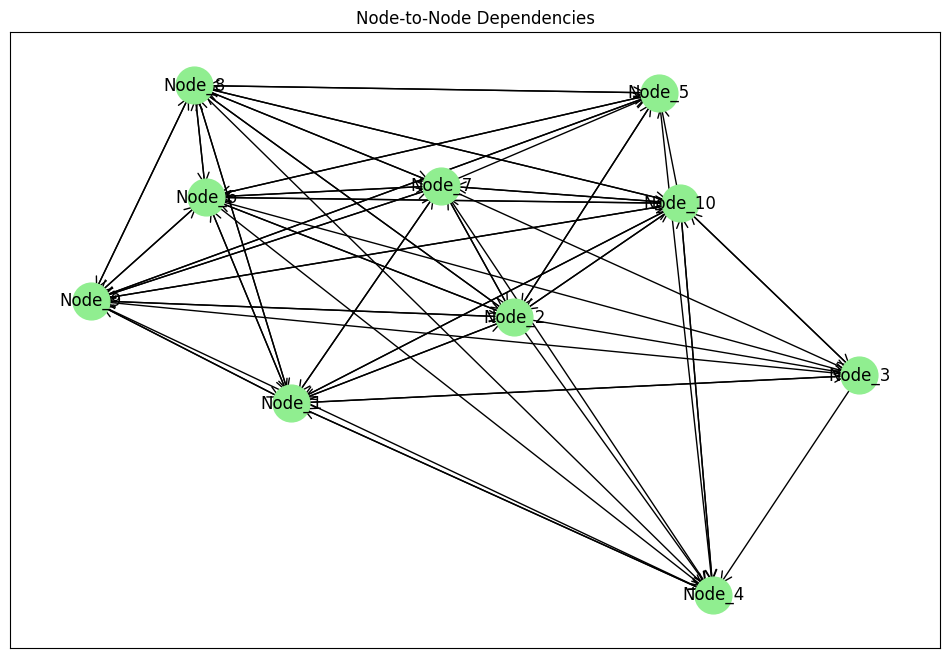

In [24]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_nodes)
nx.draw_networkx_nodes(G_nodes, pos, node_size=700, node_color='lightgreen')
nx.draw_networkx_labels(G_nodes, pos)
nx.draw_networkx_edges(G_nodes, pos, arrowstyle='->', arrowsize=20)
plt.title('Node-to-Node Dependencies')
plt.show()

## Detecting Cycling Dependencies

### Cyclic Dependency - Length = 1

In [25]:
query = """
MATCH path = (a:Application)-[:DEPENDS_ON*1]->(a)
RETURN nodes(path) AS CycleNodes, LENGTH(path) AS CycleLength
"""

df_cyclic_dependencies = fetch_data(query)
print("Cyclic Dependencies:")
for index, row in df_cyclic_dependencies.iterrows():
    cycle_nodes = [record['name'] for record in row['CycleNodes']]
    print(f"Cycle: {' -> '.join(cycle_nodes)}; Length: {row['CycleLength']}")
    

Cyclic Dependencies:
Cycle: App_42 -> App_42; Length: 1
Cycle: App_47 -> App_47; Length: 1


### Cyclic Dependency - Length = 2

In [26]:
query = """
MATCH path = (a:Application)-[:DEPENDS_ON*2]->(a)
RETURN nodes(path) AS CycleNodes, LENGTH(path) AS CycleLength
"""

df_cyclic_dependencies = fetch_data(query)
print("Cyclic Dependencies:")
for index, row in df_cyclic_dependencies.iterrows():
    cycle_nodes = [record['name'] for record in row['CycleNodes']]
    print(f"Cycle: {' -> '.join(cycle_nodes)}; Length: {row['CycleLength']}")
    

Cyclic Dependencies:
Cycle: App_10 -> App_66 -> App_10; Length: 2
Cycle: App_11 -> App_31 -> App_11; Length: 2
Cycle: App_31 -> App_11 -> App_31; Length: 2
Cycle: App_57 -> App_60 -> App_57; Length: 2
Cycle: App_60 -> App_57 -> App_60; Length: 2
Cycle: App_66 -> App_10 -> App_66; Length: 2


### Cyclic Dependency - Length = 3

In [27]:
query = """
MATCH path = (a:Application)-[:DEPENDS_ON*3]->(a)
RETURN nodes(path) AS CycleNodes, LENGTH(path) AS CycleLength
"""

df_cyclic_dependencies = fetch_data(query)
print("Cyclic Dependencies:")
for index, row in df_cyclic_dependencies.iterrows():
    cycle_nodes = [record['name'] for record in row['CycleNodes']]
    print(f"Cycle: {' -> '.join(cycle_nodes)}; Length: {row['CycleLength']}")
    

Cyclic Dependencies:
Cycle: App_1 -> App_47 -> App_72 -> App_1; Length: 3
Cycle: App_22 -> App_42 -> App_66 -> App_22; Length: 3
Cycle: App_22 -> App_42 -> App_66 -> App_22; Length: 3
Cycle: App_42 -> App_66 -> App_22 -> App_42; Length: 3
Cycle: App_42 -> App_66 -> App_22 -> App_42; Length: 3
Cycle: App_47 -> App_72 -> App_1 -> App_47; Length: 3
Cycle: App_66 -> App_22 -> App_42 -> App_66; Length: 3
Cycle: App_66 -> App_22 -> App_42 -> App_66; Length: 3
Cycle: App_72 -> App_1 -> App_47 -> App_72; Length: 3


### Cyclic Dependency - Length = 4

In [28]:
query = """
MATCH path = (a:Application)-[:DEPENDS_ON*4]->(a)
RETURN nodes(path) AS CycleNodes, LENGTH(path) AS CycleLength
"""

df_cyclic_dependencies = fetch_data(query)
print("Cyclic Dependencies:")
for index, row in df_cyclic_dependencies.iterrows():
    cycle_nodes = [record['name'] for record in row['CycleNodes']]
    print(f"Cycle: {' -> '.join(cycle_nodes)}; Length: {row['CycleLength']}")
    

Cyclic Dependencies:
Cycle: App_1 -> App_47 -> App_47 -> App_72 -> App_1; Length: 4
Cycle: App_16 -> App_44 -> App_93 -> App_71 -> App_16; Length: 4
Cycle: App_22 -> App_42 -> App_42 -> App_66 -> App_22; Length: 4
Cycle: App_22 -> App_42 -> App_42 -> App_66 -> App_22; Length: 4
Cycle: App_42 -> App_42 -> App_66 -> App_22 -> App_42; Length: 4
Cycle: App_42 -> App_42 -> App_66 -> App_22 -> App_42; Length: 4
Cycle: App_42 -> App_66 -> App_22 -> App_42 -> App_42; Length: 4
Cycle: App_42 -> App_66 -> App_22 -> App_42 -> App_42; Length: 4
Cycle: App_44 -> App_93 -> App_71 -> App_16 -> App_44; Length: 4
Cycle: App_47 -> App_72 -> App_1 -> App_47 -> App_47; Length: 4
Cycle: App_47 -> App_47 -> App_72 -> App_1 -> App_47; Length: 4
Cycle: App_66 -> App_22 -> App_42 -> App_42 -> App_66; Length: 4
Cycle: App_66 -> App_22 -> App_42 -> App_42 -> App_66; Length: 4
Cycle: App_71 -> App_16 -> App_44 -> App_93 -> App_71; Length: 4
Cycle: App_72 -> App_1 -> App_47 -> App_47 -> App_72; Length: 4
Cycle: Ap

## Ripple Effect

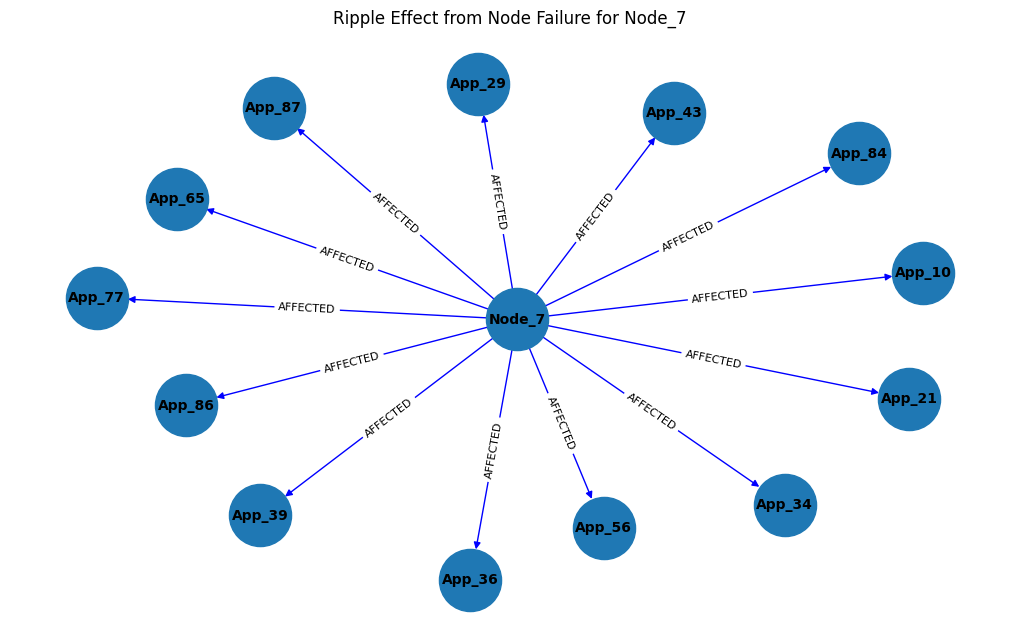

In [29]:
# Function to visualize Ripple Effect from Node Failure
def visualize_ripple_effect_directly_from_node_failure(node_name):
    G = nx.DiGraph()

    ripple_node_failure_query = f"""
    MATCH (failedNode:Node {{name: '{node_name}'}})<-[:RUNS_ON]-(affectedApp:Application)
    RETURN DISTINCT failedNode.name AS FailedNode, affectedApp.name AS AffectedApplication
    """
    result = graph.run(ripple_node_failure_query)
    for record in result:
        G.add_edge(record["FailedNode"], record["AffectedApplication"], label="AFFECTED", color="blue")

    # Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_size=2000, font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"Ripple Effect from Node Failure for {node_name}")
    plt.show()

# Run each visualization function with example data
visualize_ripple_effect_directly_from_node_failure("Node_7")

In [30]:
def find_affected_applications(tx, failed_component_name, component_type):
    if component_type == 'Application':
        query = """
        MATCH (failedApp:Application {name: $component_name})
        WITH failedApp
        MATCH path = (failedApp)<-[:DEPENDS_ON*]-(dependentApp:Application)
        RETURN DISTINCT dependentApp.name AS AffectedApplication;
        """
    elif component_type == 'Node':
        query = """
        MATCH (failedBroker:Node {name: $component_name})<-[:RUNS_ON]-(failedApp:Application)
        WITH failedApp
        MATCH path = (failedApp)<-[:DEPENDS_ON*]-(dependentApp:Application)
        RETURN DISTINCT dependentApp.name AS AffectedApplication;
        """
    elif component_type == 'Topic':
        query = """
        MATCH (initialApp:Application)-[:PUBLISHES_TO|SUBSCRIBES_TO]->(t:Topic {name: $component_name})
        WITH initialApp
        MATCH path = (initialApp)<-[:DEPENDS_ON*]-(dependentApp:Application)
        RETURN DISTINCT dependentApp.name AS AffectedApplication;
        """
    else:
        raise ValueError("Invalid component type")

    result = tx.run(query, component_name=failed_component_name)
    return [record["AffectedApplication"] for record in result]

with driver.session() as session:
    failed_component_name = 'App_10'    # Name of the failed component
    component_type = 'Application'      # 'Application', 'Broker', or 'Topic'

    affected_apps = session.execute_read(find_affected_applications, failed_component_name, component_type)

    print(f"Applications affected by failure of {component_type} {failed_component_name} and number of affected applications is {len(affected_apps)}.")
    print(affected_apps)

Applications affected by failure of Application App_10 and number of affected applications is 65.
['App_85', 'App_66', 'App_20', 'App_84', 'App_34', 'App_43', 'App_42', 'App_10', 'App_41', 'App_77', 'App_33', 'App_91', 'App_82', 'App_25', 'App_88', 'App_79', 'App_22', 'App_24', 'App_71', 'App_37', 'App_31', 'App_28', 'App_44', 'App_50', 'App_48', 'App_6', 'App_73', 'App_100', 'App_93', 'App_52', 'App_11', 'App_78', 'App_16', 'App_35', 'App_27', 'App_86', 'App_67', 'App_97', 'App_96', 'App_45', 'App_5', 'App_74', 'App_55', 'App_46', 'App_63', 'App_72', 'App_23', 'App_94', 'App_60', 'App_26', 'App_12', 'App_47', 'App_70', 'App_7', 'App_2', 'App_57', 'App_61', 'App_1', 'App_32', 'App_92', 'App_69', 'App_18', 'App_56', 'App_76', 'App_87']


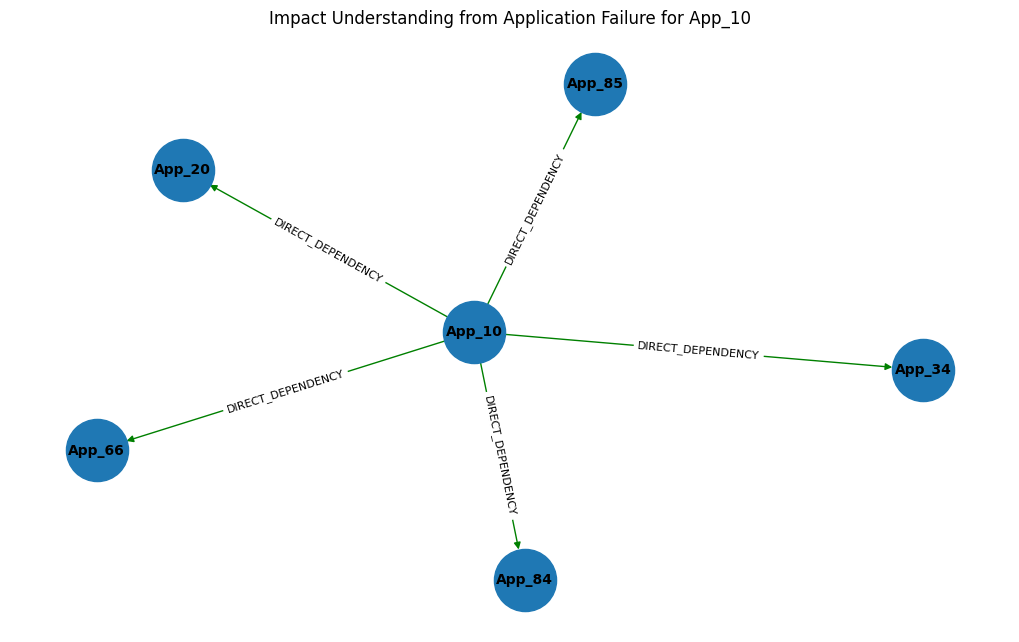

In [31]:
def visualize_impact_from_application_failure(application_name):
    G = nx.DiGraph()

    impact_understanding_query = f"""
    MATCH (failedApp:Application {{name: '{application_name}'}})
    WITH failedApp
    MATCH path = (failedApp)<-[:DEPENDS_ON*1]-(dependentApp:Application)
    RETURN DISTINCT failedApp.name AS FailedApplication, dependentApp.name AS AffectedApplication
    """
    result = graph.run(impact_understanding_query)
    for record in result:
        G.add_edge(record["FailedApplication"], record["AffectedApplication"], label="DIRECT_DEPENDENCY", color="green")

    # Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_size=2000, font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"Impact Understanding from Application Failure for {application_name}")
    plt.show()

application_name = "App_10"
visualize_impact_from_application_failure(application_name)

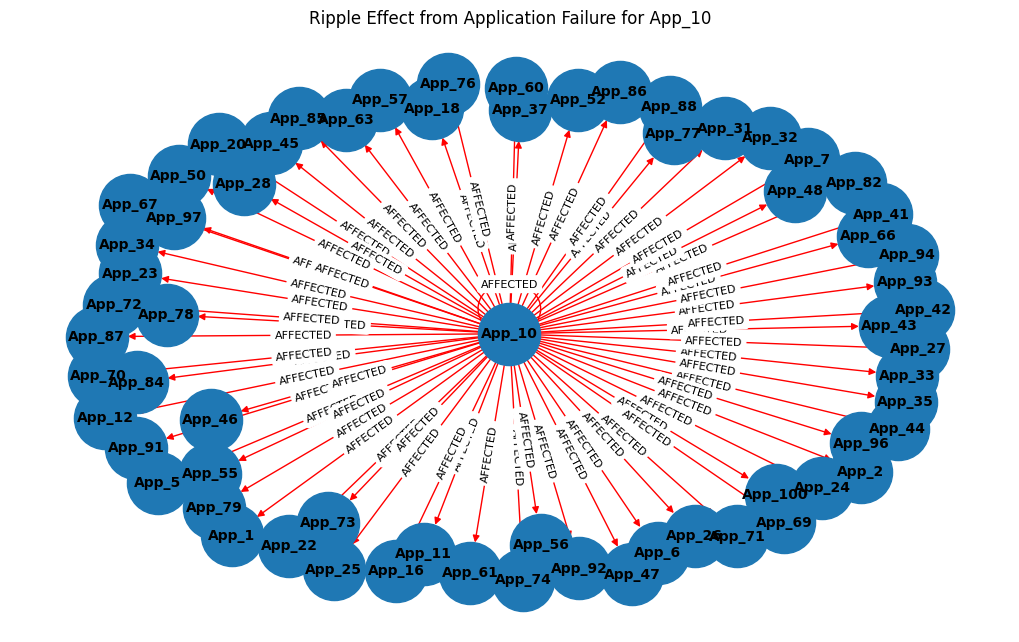

In [32]:
# Function to visualize Ripple Effect from Application Failure
def visualize_ripple_from_application_failure(application_name):
    G = nx.DiGraph()

    ripple_app_failure_query = f"""
    MATCH (failedApp:Application {{name: '{application_name}'}})
    WITH failedApp
    MATCH path = (failedApp)<-[:DEPENDS_ON*]-(dependentApp:Application)
    RETURN DISTINCT failedApp.name AS FailedApplication, dependentApp.name AS AffectedApplication
    """
    result = graph.run(ripple_app_failure_query)
    for record in result:
        G.add_edge(record["FailedApplication"], record["AffectedApplication"], label="AFFECTED", color="red")

    # Draw the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_size=2000, font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"Ripple Effect from Application Failure for {application_name}")
    plt.show()

application_name = "App_10"
visualize_ripple_from_application_failure(application_name)


## Data Visualization

### Fetching data from Neo4j

In [33]:
# Fetching application data
query = """
MATCH (a:Application)
RETURN a.name AS name
"""
apps = fetch_data(query)

# Fetching topic data
query = """
MATCH (t:Topic)
RETURN t.name AS name
"""
topics = fetch_data(query)

# Fetching node data
query = """
MATCH (n:Node)
RETURN n.name AS name
"""
nodes = fetch_data(query)

# Fetching broker data
query = """
MATCH (b:Broker)
RETURN b.name AS name
"""
brokers = fetch_data(query)

# Fetching relationships between applications and topics
query = """
MATCH (a:Application)-[r:PUBLISHES_TO|SUBSCRIBES_TO]->(t:Topic)
RETURN a.name AS source, t.name AS target, type(r) AS type
"""
app_topic_rels = fetch_data(query)

# Fetching relationships between applications
query = """
MATCH (a1:Application)-[r:DEPENDS_ON]->(a2:Application)
RETURN a1.name AS source, a2.name AS target, type(r) AS type
"""
app_app_rels = fetch_data(query)

# Fetching relationships between applications and nodes
query = """
MATCH (a:Application)-[r:RUNS_ON]->(n:Node)
RETURN a.name AS source, n.name AS target, type(r) AS type
"""
app_node_rels = fetch_data(query)

# Fetching relationships between nodes
query = """
MATCH (n1:Node)-[r:CONNECTS_TO]->(n2:Node)
RETURN n1.name AS source, n2.name AS target, type(r) AS type
"""
node_node_rels = fetch_data(query)

# Fetching relationships between brokers and nodes
query = """
MATCH (b:Broker)-[r:RUNS_ON]->(n:Node)
RETURN b.name AS source, n.name AS target, type(r) AS type
"""
broker_node_rels = fetch_data(query)


### Visualizing graph data

In [34]:
# Create NetworkX Graph
G = nx.DiGraph()

# Add Nodes
for _, row in apps.iterrows():
    G.add_node(f"{row['name']}", type='Application')
for _, row in topics.iterrows():
    G.add_node(f"{row['name']}", type='Topic')
for _, row in nodes.iterrows():
    G.add_node(f"{row['name']}", type='Node')
for _, row in brokers.iterrows():
    G.add_node(f"{row['name']}", type='Broker')

# Add Edges with relationship types
def add_edges(df):
    for _, row in df.iterrows():
        G.add_edge(row['source'], row['target'], relationship=row['type'])

add_edges(app_topic_rels)
add_edges(app_app_rels)
add_edges(app_node_rels)
add_edges(node_node_rels)
add_edges(broker_node_rels)

# Compute Layout and Node Attributes
pos = nx.spring_layout(G, k=0.15, iterations=20)
degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, 'degree')

# Betweenness Centrality
betweenness_dict = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

# Community Detection
from networkx.algorithms import community
communities = community.girvan_newman(G)
top_level_communities = next(communities)
community_dict = {node: idx for idx, comm in enumerate(top_level_communities) for node in comm}
nx.set_node_attributes(G, community_dict, 'community')

# Prepare edge traces
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Prepare node traces
node_x, node_y, node_color, node_size, node_text = [], [], [], [], []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    if G.nodes[node]['type'] == 'Application':
        node_color.append('skyblue')
    elif G.nodes[node]['type'] == 'Topic':
        node_color.append('lightgreen')
    elif G.nodes[node]['type'] == 'Node':
        node_color.append('orange')
    elif G.nodes[node]['type'] == 'Broker':
        node_color.append('lightcoral')
    else:
        node_color.append('pink')
    node_size.append(10 + G.nodes[node]['degree'] * 2)
    node_text.append(
        f"{node}<br>Type: {G.nodes[node]['type']}<br>Degree: {G.nodes[node]['degree']}<br>Betweenness: {G.nodes[node]['betweenness']:.4f}"
    )

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        color=node_color,
        size=node_size,
        line_width=2
    )
)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Distributed System Visualization',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

### Visualizing different types of dependencies

In [35]:
def visualize_relationship(G, edge_filter, title, node_colors, pos=None):
    """
    Visualizes a subgraph based on edge relationships.

    Parameters:
    - G: Original graph
    - edge_filter: Function to filter edges (e.g., lambda e: e[2]['relationship'] == 'PUBLISHES_TO')
    - title: Title of the figure
    - node_colors: Dictionary mapping node types to colors
    - pos: Precomputed layout (optional)
    """
    # Filter edges
    edges = [(u, v) for u, v, d in G.edges(data=True) if edge_filter(d)]
    subgraph = G.edge_subgraph(edges).copy()

    # Compute layout if not provided
    if pos is None:
        pos = nx.spring_layout(subgraph, k=0.15, iterations=20)

    # Prepare edge traces
    edge_x, edge_y = [], []
    for edge in subgraph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Prepare node traces
    node_x, node_y, node_color, node_size, node_text = [], [], [], [], []
    for node in subgraph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_type = G.nodes[node].get('type', 'Unknown')
        node_color.append(node_colors.get(node_type, 'gray'))
        degree = subgraph.degree[node]
        node_size.append(10 + degree * 2)
        node_text.append(f"{node}<br>Type: {node_type}<br>Degree: {degree}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            color=node_color,
            size=node_size,
            line_width=2
        )
    )

    # Create figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f"{title}",
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    fig.show()

In [36]:
# Node colors based on type
node_colors = {
    'Application': 'skyblue',
    'Topic': 'lightgreen',
    'Node': 'orange',
    'Broker': 'pink'
}

# Visualize Application -> Topic relationships
visualize_relationship(
    G,
    lambda d: d['relationship'] in ['PUBLISHES_TO', 'SUBSCRIBES_TO'],
    "Application to Topic Relationships",
    node_colors
)

# Visualize Application -> Application relationships
visualize_relationship(
    G,
    lambda d: d['relationship'] == 'DEPENDS_ON',
    "Application to Application Relationships",
    node_colors
)

# Visualize Application -> Node relationships
visualize_relationship(
    G,
    lambda d: d['relationship'] == 'RUNS_ON',
    "Application to Node Relationships",
    node_colors
)

# Visualize Node -> Node relationships
visualize_relationship(
    G,
    lambda d: d['relationship'] == 'CONNECTS_TO',
    "Node to Node Relationships",
    node_colors
)

### Application-to-Topic Network

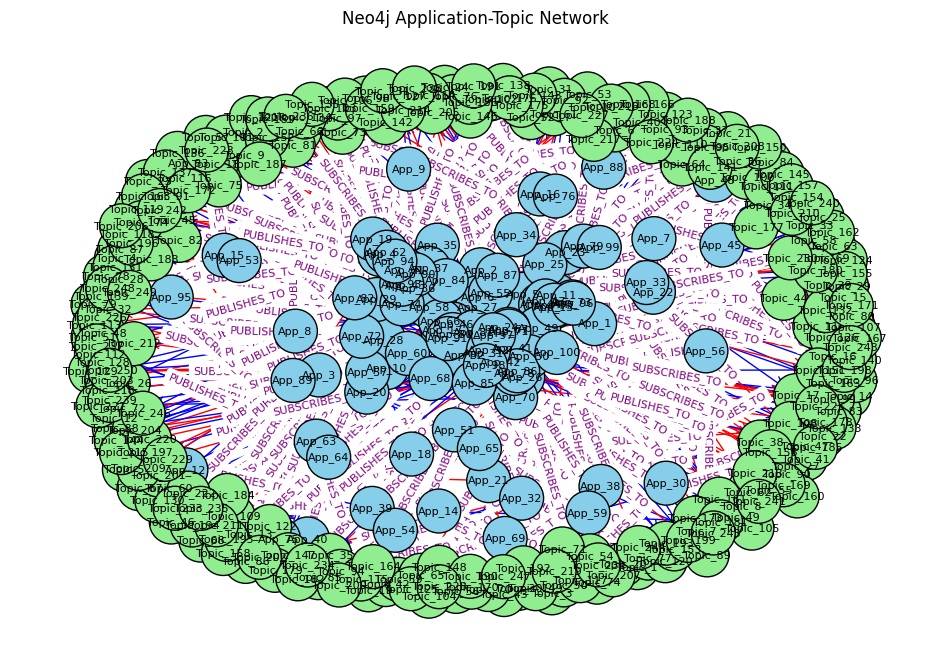

In [37]:
G = nx.DiGraph()

# Add application nodes with a specific color
for _, row in apps.iterrows():
    G.add_node(row['name'], node_type='Application', color='skyblue')

# Add topic nodes with a different color
for _, row in topics.iterrows():
    G.add_node(row['name'], node_type='Topic', color='lightgreen')

# Add edges based on relationships with labels to indicate PUBLISHES or SUBSCRIBES
for _, row in app_topic_rels.iterrows():
    G.add_edge(row['source'], row['target'], relationship=row['type'], color='blue' if row['type'] == 'PUBLISHES_TO' else 'red')

# Define colors for nodes and edges
node_colors = [G.nodes[node].get('color', 'gray') for node in G.nodes()]
edge_colors = [G.edges[edge].get('color', 'black') for edge in G.edges()]

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Set seed for consistent layout

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, edgecolors='k')
nx.draw_networkx_labels(G, pos, font_size=8)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='->', arrowsize=20)

# Add edge labels for relationship type
edge_labels = {(source, target): G.edges[source, target]['relationship'] for source, target in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='purple', font_size=8)

# Show plot
plt.title("Neo4j Application-Topic Network")
plt.axis('off')
plt.show()

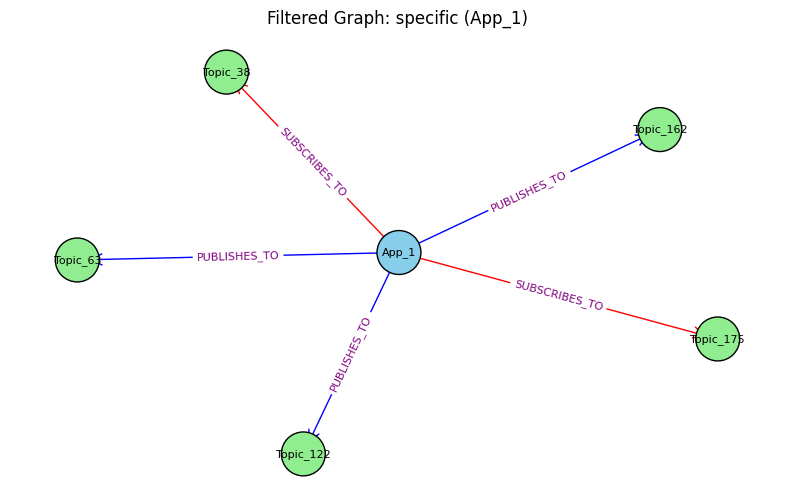

In [38]:
# Function to visualize with different filters
def plot_filtered_graph(graph, filter_type="all", specific_node=None):
    """
    Visualizes the graph with specific filters.
    
    Parameters:
        graph: NetworkX graph object
        filter_type: Filter type as string. Options are "all", "topics", "applications", "specific".
        specific_node: Specific node name to filter around (only used if filter_type is "specific").
    """
    
    if filter_type == "topics":
        # Filter to show only topic nodes and edges connected between topics
        subgraph_nodes = [node for node in graph.nodes if graph.nodes[node]['node_type'] == 'Topic']
    
    elif filter_type == "applications":
        # Filter to show only application nodes and edges connected between applications
        subgraph_nodes = [node for node in graph.nodes if graph.nodes[node]['node_type'] == 'Application']
    
    elif filter_type == "specific" and specific_node:
        # Filter to show only the specific application/topic and its immediate neighbors
        subgraph_nodes = {specific_node}
        subgraph_nodes.update(graph.successors(specific_node))
        subgraph_nodes.update(graph.predecessors(specific_node))
    
    else:
        # Default to show all nodes if no filter is applied
        subgraph_nodes = list(graph.nodes)
    
    # Create the subgraph based on the selected nodes
    subgraph = graph.subgraph(subgraph_nodes)
    
    # Extract node and edge colors for the subgraph
    node_colors = [subgraph.nodes[node].get('color', 'gray') for node in subgraph.nodes()]
    edge_colors = [subgraph.edges[edge].get('color', 'black') for edge in subgraph.edges()]

    # Draw the subgraph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph, seed=42)  # Position nodes
    
    # Draw nodes and labels
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=1000, edgecolors='k')
    nx.draw_networkx_labels(subgraph, pos, font_size=8)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, arrowstyle='->', arrowsize=20)
    
    # Add edge labels for relationship type
    edge_labels = {(source, target): subgraph.edges[source, target]['relationship'] for source, target in subgraph.edges()}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='purple', font_size=8)
    
    # Show plot
    plt.title(f"Filtered Graph: {filter_type} ({specific_node if specific_node else ''})")
    plt.axis('off')
    plt.show()

# Example usages:
plot_filtered_graph(G, filter_type="specific", specific_node="App_1")  # Show specific application and its neighbors